<h1 style="color: #3a75c4;">Heart Failure Prediction With Random Forest Model</h1>

<h2 style="color: #75aadb;">00 | Libraries</h2>

In [1]:
# 📚 Basic libraries
import pandas as pd
import numpy as np 
import shap
shap.initjs()

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# File system libraries
import os
import sys

# Add the root directory to sys.path 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Project libraries
import utils.cleanup as cl
import utils.viz as viz
import utils.classification_model as cm

# ⚙️ Settings
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #75aadb;">01 | Data Extraction</h2>

In [2]:
# Extract the clean data cvs
data = pd.read_csv('../datasets/clean_heart_disease.csv')
hd_df = data.copy()

<h2 style="color: #75aadb;">06 | Improving the Model</h2>

### Load the model

In [3]:
# Load the Random Forest model
filename = '../models/random_forest_model.pkl'
pipeline_random = cm.load_model_from_pickle(filename)

Model loaded from /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/../models/random_forest_model.pkl


In [4]:
# Load the SVM model
filename = '../models/svm_model.pkl'
pipeline_svm = cm.load_model_from_pickle(filename)

Model loaded from /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/../models/svm_model.pkl


### X-y split and Train-Test Split

In [5]:
# X and y Split
X = hd_df.drop("heartdisease", axis=1)
y = hd_df["heartdisease"]

In [6]:
# Split the data into train and test sets with a test size of 0.1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
# Create a SMOTE object for oversampling
smote = SMOTE(sampling_strategy='minority')

# Apply SMOTE for training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

<h3 style="color: #f4e287;">Hyperparameter Tuning: Random Forest </h3>

In [8]:
# Plot the max tree depth of the Random Forest model vs. the accuracy
viz.max_depth_plot(pipeline_random, X_resampled, y_resampled, X_test, y_test)

In [47]:
# Define a distribution for GridSearchCV
param_dist = {
    'classifier__n_estimators': [150, 200, 300],
    'classifier__max_depth': [14, 22],
    'classifier__min_samples_split': [3, 4],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__bootstrap': [True],
    'classifier__max_features': ['sqrt']
}

In [43]:
# Set up GridSearchCV
grid_search_forest = GridSearchCV(
    estimator=pipeline_random,                 
    param_grid=param_dist,             
    cv=8,                              
    n_jobs=-1,                      
    scoring='accuracy',                 
)

In [48]:
# Fit the model using GridSearchCV
grid_search_forest.fit(X_resampled, y_resampled)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cont',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'restingbp',
                                                                          'cholesterol',
                                                                          'maxhr',
                                                                          'oldpeak']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['sex',
                                                                          'fastingbs',
                                                                          'exerciseangina',
                                                                          'chestpaintype_ASY',
                                                                          'chestpaintype_ATA',
                                                                          'chestpaintype_NAP',
                                                                          'chestpaintype_TA',
                                                                          'restingecg_LVH',
                                                                          'restingecg_Normal',
                                                                          'restin...
                                                                          'st_slope_Flat',
                                                                          'st_slope_Up'])])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=29))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [14, 17, 22],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2, 3],
                         'classifier__min_samples_split': [2, 3, 4],
                         'classifier__n_estimators': [150, 200, 300]},
             scoring='accuracy')

In [49]:
# Get the best parameters
print("Best parameters found: ", grid_search_forest.best_params_)
print("Best accuracy score: ", grid_search_forest.best_score_)

Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 14, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Best accuracy score:  0.8744857165036485


In [50]:
# Prediction for Random Forest
y_pred_forest = grid_search_forest.predict(X_test)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_forest))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.91      0.94      0.93        54

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92



In [55]:
# Save it as Best Model for random forest
best_model_forest = grid_search_forest.best_estimator_

In [60]:
cm.save_model_to_pickle(best_model_forest, '../models/best_model.pkl')

Model saved as /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/../models/best_model.pkl


<h3 style="color: #f4e287;">Hyperparameter Tuning: SVM </h3>

In [15]:
# Define a distribution for GridSearchCV
param_dist_svm = {
    'classifier__C': [0.1, 1, 10, 100], 
    'classifier__kernel': ['rbf', 'linear'],  
    'classifier__gamma': ['auto', 'scale']  
}

In [16]:
# Set up GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=pipeline_svm,                 
    param_grid=param_dist_svm,             
    cv=8,                              
    n_jobs=-1,                      
    scoring='accuracy',                 
)

In [17]:
# Fit the model using GridSearchCV
grid_search_svm.fit(X_resampled, y_resampled)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cont',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'restingbp',
                                                                          'cholesterol',
                                                                          'maxhr',
                                                                          'oldpeak']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['sex',
                                                                          'fastingbs',
                                                                          'exerciseangina',
                                                                          'chestpaintype_ASY',
                                                                          'chestpaintype_ATA',
                                                                          'chestpaintype_NAP',
                                                                          'chestpaintype_TA',
                                                                          'restingecg_LVH',
                                                                          'restingecg_Normal',
                                                                          'restingecg_ST',
                                                                          'st_slope_Down',
                                                                          'st_slope_Flat',
                                                                          'st_slope_Up'])])),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': ['auto', 'scale'],
                         'classifier__kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [18]:
# Get the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)
print("Best accuracy score: ", grid_search_svm.best_score_)

Best parameters found:  {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best accuracy score:  0.8711380220462661


In [19]:
# Prediction for SVM
y_pred_svm = grid_search_svm.predict(X_test)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_svm))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        38
           1       0.86      0.89      0.87        54

    accuracy                           0.85        92
   macro avg       0.85      0.84      0.84        92
weighted avg       0.85      0.85      0.85        92



In [20]:
# Save it as Best Model for random forest
best_model_svm = grid_search_svm.best_estimator_

<h2 style="color: #75aadb;">07 | Reporting</h2>

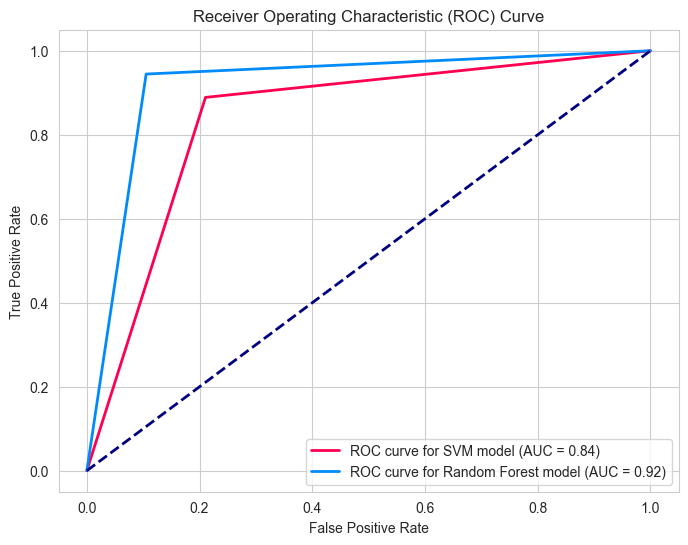

In [21]:
# ROC Curve after GridSearchCV
label1 = 'ROC curve for SVM model' 
label2 = 'ROC curve for Random Forest model'
viz.roc_curve_auc_plot(y_test, y_pred_svm, y_test, y_pred_forest, label1, label2)

In [22]:
# Access the preprocessor part of the pipeline
preprocessor = best_model_forest.named_steps['preprocessor']

# Apply transformation to the data using the preprocessor
X_transformed = preprocessor.transform(X_resampled)

# Create the SHAP explainer using the classifier
explainer = shap.TreeExplainer(best_model_forest.named_steps['classifier'], X_transformed)

# Get SHAP values
shap_values = explainer.shap_values(X_transformed, check_additivity=False)

100%|===================| 1812/1816 [07:26<00:00]        

In [23]:
# Get the SHAP values for the target = 1 (heart disease)
shap_values_class_1 = shap_values[:, :, 1]

# Wrap the SHAP values for class 0 into an Explanation object
shap_values_class_1_explainer = shap.Explanation(values=shap_values_class_1, 
                                                 data=X_transformed, 
                                                 feature_names=X_train.columns)

In [61]:
cm.save_model_to_pickle(shap_values_class_1_explainer, '../models/shap_values.pkl')

Model saved as /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/../models/shap_values.pkl


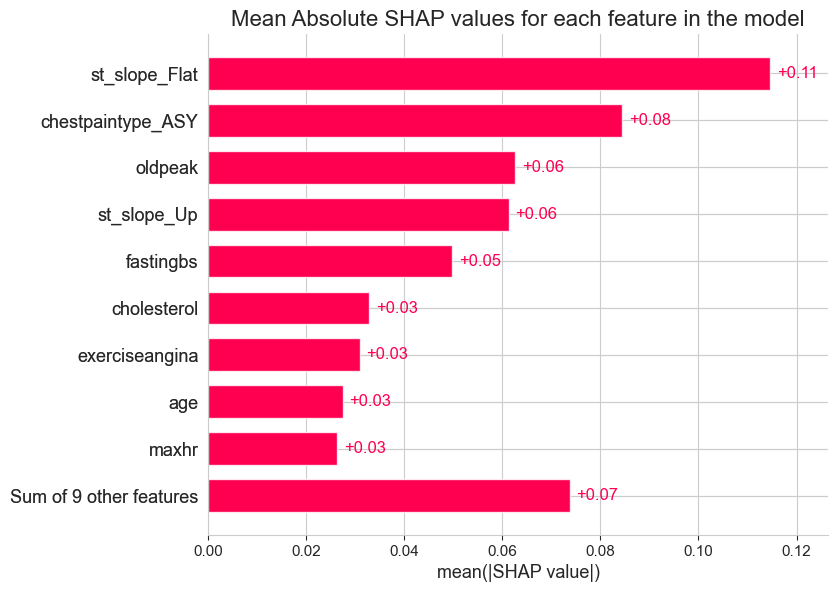

In [24]:
# Plot the bar plot for the SHAP values
viz.shap_bar_plot(shap_values_class_1_explainer)

- In this plot we can see the average contribution of the feature to the target.

- `st_slope_Flat` and `chestpaintype_ASY` are the ones that most contributed in average.

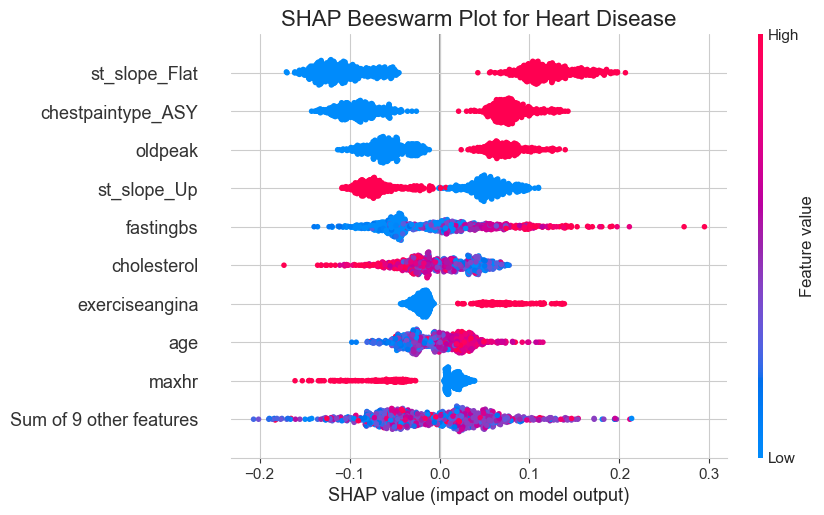

In [25]:
# Plot the SHAP beeswarm plot for Heart Disease
viz.shap_beeswarm_plot(shap_values_class_1_explainer)

- The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature.

- In this model we can see how the value of each feature is contributing to the heart disease prediction.

- The presence of `st_slope_Flat`, `chestpaintype_ASY` and `oldpeak`, and the absence of `st_slope_Up` are indicators of heart disease (high impact on the model).